# Example usage of AddCloudMaskTask

Notebook showing some usage examples of the `mask.eotask_cloud_mask` module

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import BBox, CRS

from eolearn.core.eoworkflow import EOWorkflow, Dependency
from eolearn.io import S2L1CWMSInput, S2L1CWCSInput
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector

Define ROI BBOX and time interval

In [2]:
roi_bbox = BBox([128.689942, 37.656454, 128.722946, 37.677434], crs=CRS.WGS84)

time_interval = ('2016-01-01', '2016-04-01')

### Compute cloud maps from new WMS request

In this workflow example, the cloud maps are computed from a new WMS request, as the input eopatch does not have the required data 

In [3]:
layer = 'TRUE-COLOR-S2-L1C'

wms_task = S2L1CWMSInput(layer=layer, height=200, maxcc=1)

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2-L1C', cm_size_y=100, cmask_feature='CLM', cprobs_feature='CLP')

Finished loading model, total used 170 iterations


Run workflow

In [4]:
workflow = EOWorkflow([
    Dependency(wms_task, inputs=[]),
    Dependency(add_clm, inputs=[wms_task])
])

result = workflow.execute({wms_task: {'bbox': roi_bbox, 'time_interval': time_interval}})

Plot results

In [5]:
result[add_clm]

EOPatch(
  data: {
    CLP: numpy.ndarray(shape=(13, 200, 252, 1), dtype=float32)
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(13, 200, 252, 3), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(13, 200, 252, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(13, 200, 252, 1), dtype=uint8)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1
    service_type: 'wms'
    size_x: None
    size_y: 200
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: [datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2016, 4, 1, 0, 0)]
  }
  bbox: BBox(((128.689942, 37.656454), (128.722946, 37.677434)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2016, 1, 6, 2, 17, 17), ..., datetime.datetime(2016, 3, 29, 2, 26, 53)], length=13
)

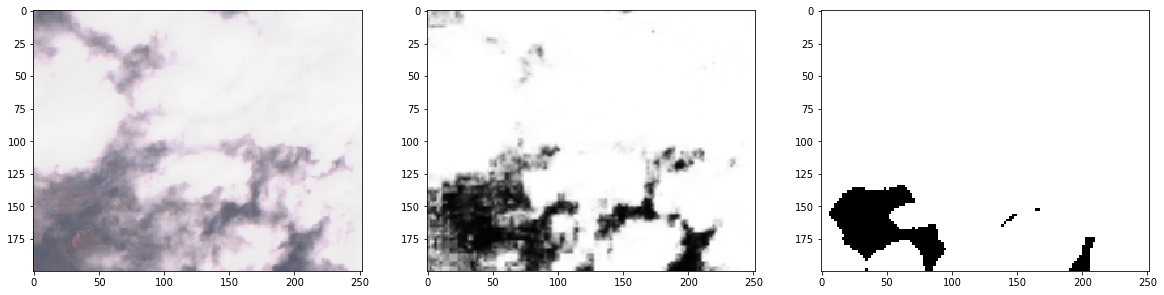

In [6]:
fig = plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(result[add_clm].data['TRUE-COLOR-S2-L1C'][10])
plt.subplot(132)
plt.imshow(np.squeeze(result[add_clm].data['CLP'][10]), cmap='gray')
plt.subplot(133)
plt.imshow(np.squeeze(result[add_clm].mask['CLM'][10]), cmap='gray')

In [7]:
del cloud_classifier, add_clm, workflow

### Compute cloud maps from new WCS request

In this workflow example, the cloud maps are computed from a new WCS request, as the input eopatch does not have the required data 

In [8]:
layer = 'TRUE-COLOR-S2-L1C'

wcs_task = S2L1CWCSInput(layer=layer, resx='10m', resy='10m', maxcc=1)

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='20m', cm_size_x='20m', cmask_feature='CLM',
                           cprobs_feature='CLP')

Finished loading model, total used 170 iterations


In [9]:
workflow = EOWorkflow([
    Dependency(wcs_task, inputs=[]),
    Dependency(add_clm, inputs=[wcs_task])
])

result = workflow.execute({wcs_task: {'bbox': roi_bbox, 'time_interval': time_interval}})

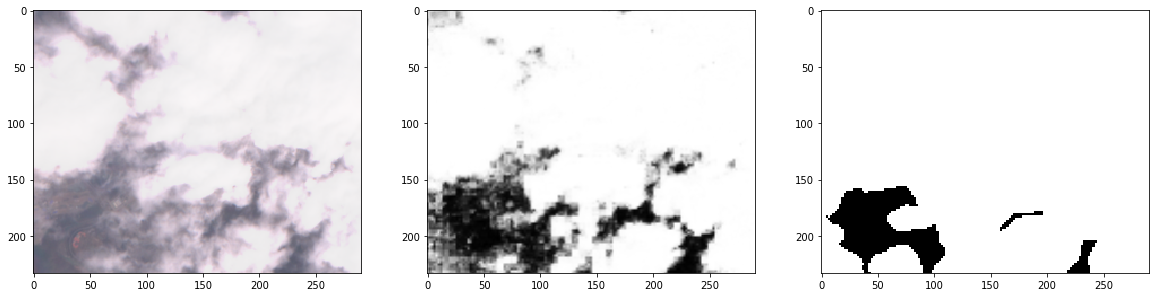

In [10]:
fig = plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(result[add_clm].data['TRUE-COLOR-S2-L1C'][10])
plt.subplot(132)
plt.imshow(np.squeeze(result[add_clm].data['CLP'][10]), cmap='gray')
plt.subplot(133)
plt.imshow(np.squeeze(result[add_clm].mask['CLM'][10]), cmap='gray')

In [11]:
del cloud_classifier, add_clm, workflow, layer

### Compute cloud mask from existing eopatch feature (WMS-style resolution request)

In this workflow example, the cloud maps are computed from an existing feature in the eopatch data dictionary

In [12]:
layer = 'BANDS-S2-L1C'

wms_task = S2L1CWMSInput(layer=layer, height=200, maxcc=1)

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=True)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2-L1C', cm_size_y=100, cmask_feature='CLM', cprobs_feature='CLP')

Finished loading model, total used 170 iterations


In [13]:
workflow = EOWorkflow([
    Dependency(wms_task, inputs=[]),
    Dependency(add_clm, inputs=[wms_task])
])

result = workflow.execute({wms_task: {'bbox': roi_bbox, 'time_interval': time_interval}})

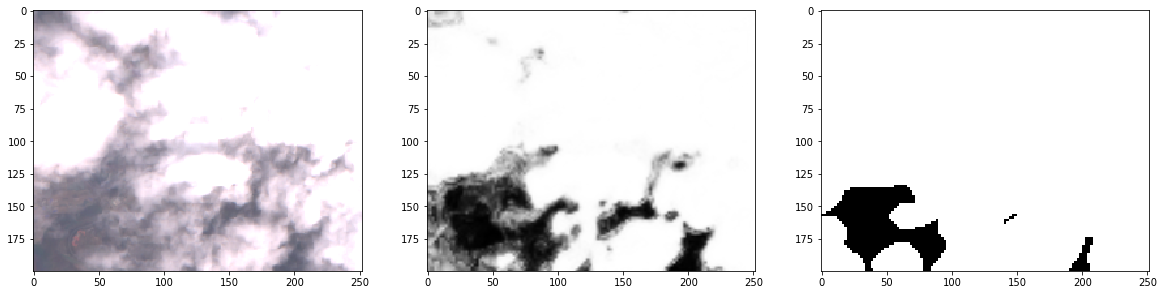

In [14]:
fig = plt.figure(figsize=(20,6))
plt.subplot(131)
img = result[add_clm].data['BANDS-S2-L1C'][10]
plt.imshow(img[..., [3,2,1]]*2.5)
plt.subplot(132)
plt.imshow(np.squeeze(result[add_clm].data['CLP'][10]), cmap='gray')
plt.subplot(133)
plt.imshow(np.squeeze(result[add_clm].mask['CLM'][10]), cmap='gray');

In [15]:
del cloud_classifier, add_clm, workflow

### Compute cloud mask from existing eopatch feature (WCS-style resolution request)

In this workflow example, the cloud maps are computed from an existing feature in the eopatch data dictionary

In [16]:
layer = 'BANDS-S2-L1C'

wcs_task = S2L1CWCSInput(layer=layer, resx='10m', resy='10m', maxcc=1)

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=True)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2-L1C', cm_size_y='20m', cm_size_x='20m', cmask_feature='CLM',
                           cprobs_feature='CLP')

Finished loading model, total used 170 iterations


In [17]:
workflow = EOWorkflow([
    Dependency(wcs_task, inputs=[]),
    Dependency(add_clm, inputs=[wcs_task])
])

result = workflow.execute({wcs_task: {'bbox': roi_bbox, 'time_interval': time_interval}})

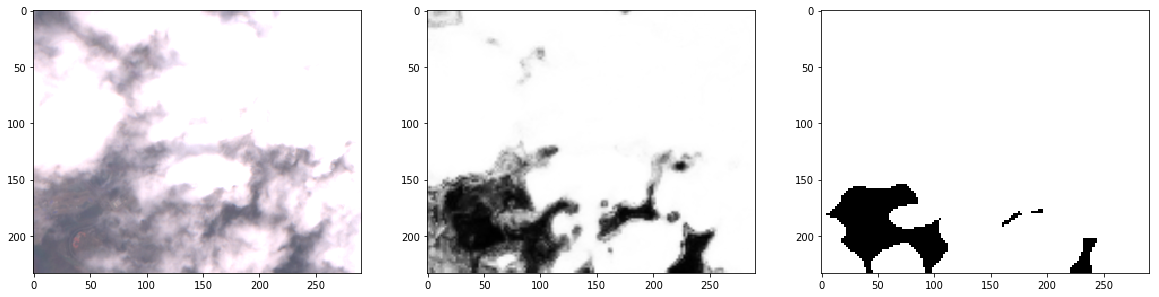

In [18]:
fig = plt.figure(figsize=(20,6))
plt.subplot(131)
img = result[add_clm].data['BANDS-S2-L1C'][10]
plt.imshow(img[..., [3,2,1]]*2.5)
plt.subplot(132)
plt.imshow(np.squeeze(result[add_clm].data['CLP'][10]), cmap='gray')
plt.subplot(133)
plt.imshow(np.squeeze(result[add_clm].mask['CLM'][10]), cmap='gray');

In [19]:
del cloud_classifier, add_clm, workflow, layer